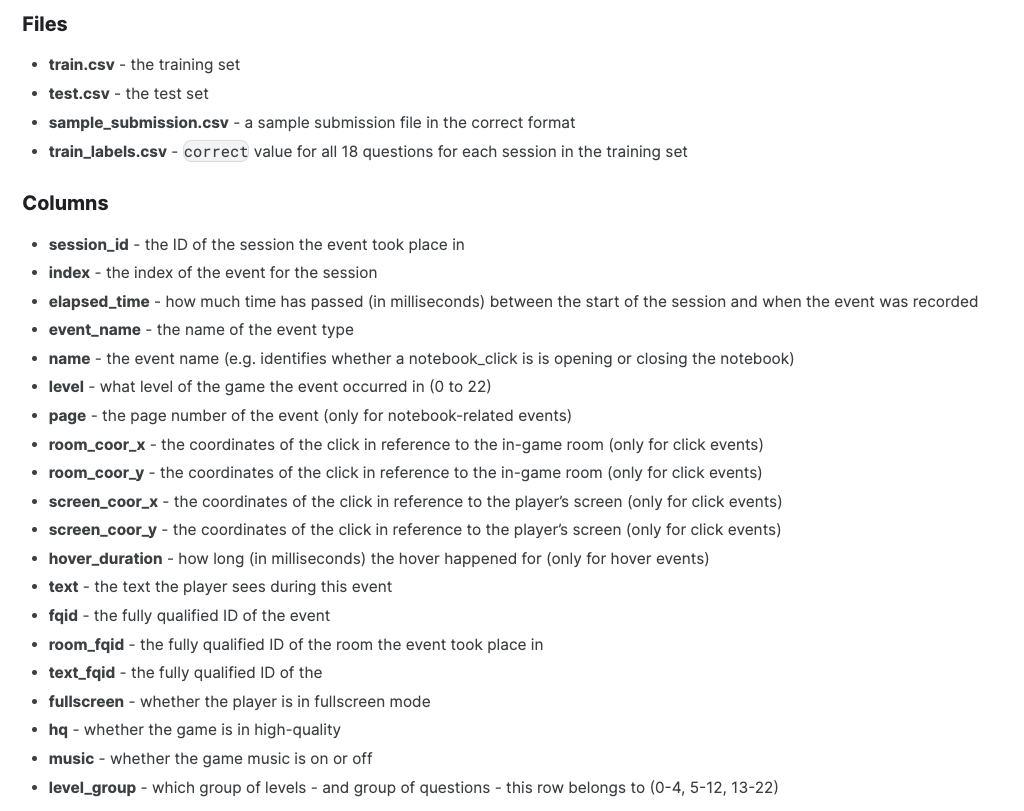

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.8 MB/s eta 0:00:00


In [ ]:
import os
import gc
import pickle
import random
import warnings
warnings.simplefilter("ignore")
from abc import abstractmethod
from copy import deepcopy
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
from torch import optim, Tensor
from torch.nn import Module
from torch.optim import Optimizer, lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.loss import _Loss
from torchmetrics import AUROC

N_QNS = 18
LEVEL = list(range(23))
LEVEL_GROUP = ["0-4", "5-12", "13-22"]
LVGP_ORDER = {"0-4": 0, "5-12": 1, "13-22": 2}
QNS_PER_LV_GP = {"0-4": list(range(1, 4)), "5-12": list(range(4, 14)), "13-22": list(range(14, 19))}
LV_PER_LV_GP = {"0-4": list(range(0, 5)), "5-12": list(range(5, 13)), "13-22": list(range(13, 23))}
CAT_FEAT_SIZE = {
    "event_comb_code": 19,
    "room_fqid_code": 19,
}

# Data Preprocessing

In [ ]:
class CFG:
    # ==Mode==
    # Specify True to enable model training
    train = True
    
    # ==Data===
    FEATS = ["et_diff", "event_comb_code", "room_fqid_code","screen_coor_diff"]
    CAT_FEATS = ["event_comb_code", "room_fqid_code"]
    COLS_TO_USE = ["session_id", "level", "level_group", "elapsed_time",
                   "event_name", "name", "room_fqid","screen_coor_x","screen_coor_y"]
    T_WINDOW = 1000
    
    # ==Training==
    SEED = 42
    DEVICE = "cuda:0"
    EPOCH = 8
    CKPT_METRIC = "f1@0.63"

    # ==DataLoader==
    BATCH_SIZE = 128
    NUM_WORKERS: 4

    # ==Solver==
    LR = 1e-3
    WEIGHT_DECAY = 1e-4

    # ==Early Stopping==
    ES_PATIENCE = 0
    
    # ==Evaluator==
    EVAL_METRICS = ["auroc", "f1"]

INPUT_PATH = "/content/gdrive/MyDrive/CIS522/predict-student-performance-from-game-play/train.csv"
TARGET_PATH = "/content/gdrive/MyDrive/CIS522/predict-student-performance-from-game-play/train_labels.csv"
cfg = CFG()
# seed_all(cfg.SEED)

In [ ]:
# @title Useful EDA functions
def summarize(
    df: pd.DataFrame,
    file_name: Optional[str] = None,
    n_rows_to_display: Optional[int] = 5,
) -> None:
    """Summarize DataFrame.

    Parameters:
        df: input data
        file_name: name of the input file
        n_rows_to_display: number of rows to display

    Return:
        None
    """
    file_name = "Data" if file_name is None else file_name

    # Derive NaN ratio for each column
    nan_ratio = pd.isna(df).sum() / len(df) * 100
    nan_ratio.sort_values(ascending=False, inplace=True)
    nan_ratio = nan_ratio.to_frame(name="NaN Ratio").T

    # Derive zero ratio for each column
    zero_ratio = (df == 0).sum() / len(df) * 100
    zero_ratio.sort_values(ascending=False, inplace=True)
    zero_ratio = zero_ratio.to_frame(name="Zero Ratio").T

    # Print out summarized information
    print(f"=====Summary of {file_name}=====")
    display(df.head(n_rows_to_display))
    print(f"Shape: {df.shape}")
    print("NaN ratio:")
    display(nan_ratio)
    print("Zero ratio:")
    display(zero_ratio)
    
def drop_multi_game_naive(
    df: pd.DataFrame,
    local: bool = True
) -> pd.DataFrame:
    """Drop events not occurring at the first game play.
    
    Note: `groupby` should be done with `sort=False` for the new
    training set, because `session_id` isn't sorted by default.
    
    Parameters:
        df: input DataFrame
        local: if False, the processing step is simplified based on the
            properties of returned test DataFrame by time series API
    
    Return:
        df: DataFrame with events occurring at the first game play only
    """
    df = df.copy()
    if local:
        df["lv_diff"] = df.groupby("session_id", sort=False).apply(lambda x: x["level"].diff().fillna(0)).values
    else:
        df["lv_diff"] = df["level"].diff().fillna(0)
    reversed_lv_pts = df["lv_diff"] < 0
    df.loc[~reversed_lv_pts, "lv_diff"] = 0
    if local:
        df["multi_game_flag"] = df.groupby("session_id", sort=False)["lv_diff"].cumsum().values
    else:
        df["multi_game_flag"] = df["lv_diff"].cumsum()
    multi_game_mask = df["multi_game_flag"] < 0
    multi_game_rows = df[multi_game_mask].index
    df = df.drop(multi_game_rows).reset_index(drop=True)
    
    # Drop redundant columns
    df.drop(["lv_diff", "multi_game_flag"], axis=1, inplace=True)
    
    return df

def map_lvgp_order(lvgp_seq: pd.Series) -> pd.Series:
    """Map level_group sequence to level_group order sequence.
    
    Parameters:
        lvgp_seq: level_group sequence
    
    Return:
        lvgp_order_seq: level_group order sequence
    """
    lvgp_order_seq = lvgp_seq.map(LVGP_ORDER)
    
    return lvgp_order_seq

def check_multi_game(df: pd.DataFrame) -> bool:
    """Check if multiple game plays exist in any session.
    
    Parameters:
        df: input DataFrame
    
    Return:
        multi_game_exist: if True, multiple game plays exist in at
            least one of the session
    """
    multi_game_exist = False
    for i, (sess_id, gp) in enumerate(df.groupby("session_id", sort=False)):
        if ((not gp["level"].is_monotonic_increasing)
            or (not gp["lvgp_order"].is_monotonic_increasing)):
            multi_game_exist = True
            break
            
    return multi_game_exist

In [ ]:
df = pd.read_csv(INPUT_PATH, usecols=cfg.COLS_TO_USE)
y = pd.read_csv(TARGET_PATH)

In [ ]:
summarize(df, "X", 2); summarize(y, "y", 2)

=====Summary of X=====


,session_id,elapsed_time,event_name,name,level,screen_coor_x,screen_coor_y,room_fqid,level_group
0,20090312431273200,0,cutscene_click,basic,0,380.0,494.0,tunic.historicalsociety.closet,0-4
1,20090312431273200,1323,person_click,basic,0,380.0,494.0,tunic.historicalsociety.closet,0-4


Shape: (13174211, 9)
NaN ratio:


,screen_coor_x,screen_coor_y,session_id,elapsed_time,event_name,name,level,room_fqid,level_group
NaN Ratio,7.86567,7.86567,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Zero ratio:


,level,elapsed_time,screen_coor_x,screen_coor_y,session_id,event_name,name,room_fqid,level_group
Zero Ratio,2.62084,0.089425,0.021838,0.000744,0.0,0.0,0.0,0.0,0.0


=====Summary of y=====


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0


Shape: (212022, 2)
NaN ratio:


,session_id,correct
NaN Ratio,0.0,0.0


Zero ratio:


,correct,session_id
Zero Ratio,29.605418,0.0


In [ ]:
df = drop_multi_game_naive(df)
df["lvgp_order"] = map_lvgp_order(df["level_group"])
if check_multi_game(df):
    print("There exist multiple game plays in at least one session.")

In [ ]:
df.head()

,session_id,elapsed_time,event_name,name,level,screen_coor_x,screen_coor_y,room_fqid,level_group,lvgp_order
0,20090312431273200,0,cutscene_click,basic,0,380.0,494.0,tunic.historicalsociety.closet,0-4,0
1,20090312431273200,1323,person_click,basic,0,380.0,494.0,tunic.historicalsociety.closet,0-4,0
2,20090312431273200,831,person_click,basic,0,380.0,494.0,tunic.historicalsociety.closet,0-4,0
3,20090312431273200,1147,person_click,basic,0,380.0,494.0,tunic.historicalsociety.closet,0-4,0
4,20090312431273200,1863,person_click,basic,0,381.0,494.0,tunic.historicalsociety.closet,0-4,0


## feature engineering

In [ ]:
# Generate numeric map based on unique occurance
def get_factorize_map(
    values: Union[np.ndarray, pd.Series, pd.Index],
    sort: bool = True
) -> Dict[str, int]:
    """Factorize array and return numeric representation map.

    Parameters:
        values: 1-D sequence to factorize
        sort: whether to sort unique values

    Return:
        val2code: mapping from value to numeric code
    """
    if isinstance(values, np.ndarray):
        values = pd.Series(values)

    vals_uniq = values.unique()
    if sort:
        vals_uniq = sorted(vals_uniq)
    val2code = {val: code for code, val in enumerate(vals_uniq)}

    return val2code

In [ ]:
# Generate the only numeric feature
df["et_diff"] = df.groupby("session_id", sort=False).apply(lambda x: x["elapsed_time"].diff().fillna(0)).values
df["screen_coor_diff"] = df.groupby("session_id", sort=False).apply(lambda x: (x["screen_coor_x"]+x["screen_coor_y"]).diff().fillna(0)).values
df["et_diff"] = df["et_diff"].clip(0, 3.6e6)

# Factorize categorical features
df["event_comb"] = df["event_name"] + "_" + df["name"]
for cat_feat in cfg.CAT_FEATS:
    orig_col = cat_feat[:-5]
    cat2code = get_factorize_map(df[orig_col])
    df[cat_feat] = df[orig_col].map(cat2code)
    
    with open(f"./{orig_col}2code.pkl", "wb") as f:
        pickle.dump(cat2code, f)
        
X = df[["session_id", "level_group", "level"] + cfg.FEATS]
del df; _ = gc.collect()

In [ ]:
X

,session_id,level_group,level,et_diff,event_comb_code,room_fqid_code,screen_coor_diff
0,20090312431273200,0-4,0,0.0,1,7,0.0
1,20090312431273200,0-4,0,1323.0,18,7,0.0
2,20090312431273200,0-4,0,0.0,18,7,0.0
3,20090312431273200,0-4,0,316.0,18,7,0.0
4,20090312431273200,0-4,0,716.0,18,7,1.0
...,...,...,...,...,...,...,...
13106763,22100221145014656,13-22,22,1046.0,6,2,-41.0
13106764,22100221145014656,13-22,22,1935.0,6,2,10.0
13106765,22100221145014656,13-22,22,751.0,6,2,62.0
13106766,22100221145014656,13-22,22,836.0,6,2,-70.0


## Process Labels

In [ ]:
y["q"] = y["session_id"].apply(lambda x: x.split("_q")[1]).astype(int)
y["session_id"] = y["session_id"].apply(lambda x: x.split("_q")[0]).astype(int)
y = y.sort_values(["session_id", "q"]).reset_index(drop=True)
qn2lvgp = {qn: lv_gp for lv_gp, qns in QNS_PER_LV_GP.items() for qn in qns}
y["level_group"] = y["q"].map(qn2lvgp)
y_lvgp = y.groupby(["session_id", "level_group"]).apply(lambda x: list(x["correct"])).reset_index()
y_lvgp["lvgp_order"] = y_lvgp["level_group"].map(LVGP_ORDER)
y_lvgp = y_lvgp.sort_values(["session_id", "lvgp_order"]).reset_index(drop=True)
y_lvgp.rename({0: "correct"}, axis=1, inplace=True)
y_lvgp.drop(["lvgp_order"], axis=1, inplace=True)

print("=====Labels Aggregated by `level_group`=====")
y_lvgp.head(3)

=====Labels Aggregated by `level_group`=====


,session_id,level_group,correct
0,20090312431273200,0-4,"[1, 1, 1]"
1,20090312431273200,5-12,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]"
2,20090312431273200,13-22,"[1, 1, 0, 1, 1]"


In [ ]:
y_all = y_lvgp.groupby("session_id").apply(lambda x: list(x["correct"])).reset_index()
ans_tmp = np.array(list(y_all.apply(lambda x: np.concatenate(x[0]), axis=1).values))
y_all.drop(0, axis=1, inplace=True)
y_all[list(range(18))] = ans_tmp
y_all = y_all.set_index("session_id").sort_index()

print("=====Flattened Labels=====")
y_all.head(3)

=====Flattened Labels=====


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
session_id,,,,,,,,,,,,,,,,,,
20090312431273200,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1
20090312433251036,0,1,1,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1
20090314121766812,1,1,1,0,0,1,1,0,0,1,1,1,0,1,1,1,0,1


In [ ]:
del y; _ = gc.collect()

# Define Dataset

In [ ]:
[feat for feat in cfg.FEATS if feat not in cfg.CAT_FEATS]

['et_diff', 'screen_coor_diff']

In [ ]:
class LvGpDataset(Dataset):
    """Dataset for `level_group`-wise modeling.

    Input data are all from the same `level_group`. Also, if `t_window`
    isn't long enough, only raw features from the last level of a
    `level_group` is retrieved.

    Commonly used notations are summarized as follows:
    * `N` denotes the number of samples
    * `P` denotes the length of lookback time window
    * `Q` denotes the number of questions in the current level group
    * `C` denotes the number of channels (numeric features)
        *Note: Currently, only `et_diff` is used as the numeric feature
    * `M` denotes the number of categorical features

    Each sample is session-specific, which is illustrated as follows:

    Let C=1 (i.e., only `et_diff` is used as the feature) and P=60, we
    have data appearance like:

    idx  t-59  t-58  ...  t-1  t
    0     1     2          0   2   -> session_id == 20090312431273200
    1     2     3          4   1   -> session_id == 20090312433251036
    .
    .
    .
    N-2
    N-1

    Parameters:
        data: input data
        t_window: length of lookback time window
    """

    n_samples: int

    def __init__(
        self,
        data: Tuple[pd.DataFrame, pd.DataFrame],
        t_window: int,
        **kwargs: Any,
    ) -> None:
        self.X_base, self.y_base = data
        #         self.y_base["correct"] = self.y_base["correct"].apply(lambda x: ast.literal_eval(x))
        self.t_window = t_window
        
        # Specify features to use
        self.feats = [feat for feat in cfg.FEATS if feat not in cfg.CAT_FEATS]
        self.cat_feats = cfg.CAT_FEATS

        # Setup level-related metadata
        self.lv_gp = self.X_base["level_group"].unique()[0]
        self.levels = LV_PER_LV_GP[self.lv_gp]
        self.n_lvs = len(self.levels)

        # Generate data samples
        self._chunk_X_y()
        self._set_n_samples()

    def __len__(self) -> int:
        return self.n_samples

    def __getitem__(self, idx: int) -> Dict[str, Tensor]:
        X = self.X[idx, ...]
        y = self.y[idx, ...]
        X_cat = self.X_cat[idx, ...]
        
        data_sample = {
            "X": torch.tensor(X, dtype=torch.float32),
            "X_cat": torch.tensor(X_cat, dtype=torch.int32),
            "y": torch.tensor(y, dtype=torch.float32),
        }

        return data_sample

    def _set_n_samples(self) -> None:
        """Derive the number of samples."""
        self.n_samples = len(self.X)

    def _chunk_X_y(self) -> None:
        """Chunk data samples."""
        X, y = [], []
        X_cat = []

        for sess_id in self.y_base["session_id"].values:
            # Target columns hard-coded temporarily
            X_sess = self.X_base[self.X_base["session_id"] == sess_id]
            
            pad_len = 0
            x_num = []
            # pad numerical features
            for i, feat in enumerate(self.feats): # in ["et_diff"]
                x_num_i = X_sess[feat].values[-self.t_window :]
                if i == 0 and len(x_num_i) < self.t_window:
                    pad_len = self.t_window - len(x_num_i)
                
                if pad_len != 0:
                    # pad pad_len 0's to the beginning
                    x_num_i = np.pad(x_num_i, (pad_len, 0), "constant")
                    
                x_num.append(x_num_i)
            
            x_cat = X_sess[self.cat_feats].values[-self.t_window :]
            # pad categorical features
            if pad_len != 0:
                # pad -1 to the begining to each cat feature
                x_cat = np.pad(x_cat, ((pad_len, 0), (0, 0)), "constant", constant_values=-1)  # (P, M)

            x_num = np.stack(x_num, axis=1)   # (P, C)
            X.append(x_num)
            X_cat.append(x_cat)
            y.append(self.y_base[self.y_base["session_id"] == sess_id]["correct"].values[0])
        
        self.X = np.stack(X)  # (N, P, C)
        self.X_cat = np.stack(X_cat)  # (N, P, M)
        self.y = np.vstack(y)  # (N, Q)

In [ ]:
a = [[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]]
np.pad(a, ((2, 3), (1, 2)), 'constant', constant_values=-1)


array([[-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1,  1,  2,  3,  4,  5, -1, -1],
       [-1,  1,  2,  3,  4,  5, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1]])

In [ ]:
def build_dataloaders(
    data_tr: Tuple[pd.DataFrame, pd.DataFrame],
    data_val: Tuple[pd.DataFrame, pd.DataFrame],
    batch_size: int,
    **dataset_cfg: Any,
) -> Tuple[DataLoader, Optional[DataLoader]]:
    """Create and return train and validation dataloaders.

    Parameters:
        data_tr: training data
        data_val: validation data
        dataloader_cfg: hyperparameters of dataloader
        dataset_cfg: hyperparameters of customized dataset

    Return:
        train_loader: training dataloader
        val_loader: validation dataloader
    """
    if data_tr is not None:
        train_loader = DataLoader(
            LvGpDataset(data_tr, **dataset_cfg),
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            collate_fn=None,
        )
    else:
        train_loader = None
    if data_val is not None:
        val_loader = DataLoader(
            LvGpDataset(data_val, **dataset_cfg),
            batch_size=batch_size,
            shuffle=False,  # Hard-coded
            num_workers=2,
            collate_fn=None,
        )
    else:
        val_loader = None

    return train_loader, val_loader

# Model

In [ ]:
class TConvLayer(nn.Module):
    """Dilated temporal convolution layer.
    
    Considering the time cost, I currently disable dilation.
    """
    
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        kernel_size: int,
        dilation: int,
        bias: bool = True,
        act: str = "relu",
        dropout: float = 0.1,
    ):
        super(TConvLayer, self).__init__()
        
        # Network parameters
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.bias = bias
        
        # Model blocks
        self.conv = nn.utils.weight_norm(
            nn.Conv1d(in_dim, out_dim, kernel_size, dilation=dilation, bias=bias),
            dim=None
        )
        self.bn = nn.BatchNorm1d(out_dim)
        if act == "relu":
            self.act = nn.ReLU()
        if dropout == 0:
            self.dropout = None
        else:
            self.dropout = nn.Dropout(dropout)
            
    def forward(self, x: Tensor) -> Tensor:
        """Forward pass.
        
        Shape:
            x: (B, C', P)
        """
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        if self.dropout is not None:
            x = self.dropout(x)
            
        return x
    

class EventAwareEncoder(nn.Module):
    """Event-aware encoder based on 1D-Conv."""
    
    def __init__(
        self,
        h_dim: int = 128,
        out_dim: int = 128,
        readout: bool = True,
        skip: bool = True,
        cat_feats: List[str] = ["event_comb_code", "room_fqid_code"]
    ):
        super(EventAwareEncoder, self).__init__()

        # Network parameters
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.cat_feats = cat_feats
        self.lstm = nn.LSTM(input_size=2, hidden_size=h_dim, batch_first=True)
    

    def forward(self, x: Tensor, x_cat: Tensor) -> Tensor:
        """Forward pass.

        Shape:
            x: (B, P, C)
            x_cat: (B, P, M)
        """

        # Categorical embeddings
        x, (hn, cn) = self.lstm(x) #(B, 128)
        x = x[:,-1,:]
        return x


class EventConvSimple(nn.Module):

    def __init__(self, n_lvs: int, out_dim: int, **model_cfg: Any):
        self.name = self.__class__.__name__
        super(EventConvSimple, self).__init__()

        enc_out_dim = 128 

        # Network parameters
        self.n_lvs = n_lvs
        self.out_dim = out_dim
        self.cat_feats = model_cfg["cat_feats"]
        
        self.encoder = EventAwareEncoder(h_dim=128, out_dim=enc_out_dim, readout= True, skip= False, cat_feats=self.cat_feats)

        #final classfication 
        self.clf = nn.Sequential(
            nn.Linear(enc_out_dim, enc_out_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(enc_out_dim // 2, out_dim),
        )

    def forward(self, x: Tensor, x_cat: Tensor) -> Tensor:
        """Forward pass.

        Shape:
            x: (B, P, C)
            x_cat: (B, P, M)
        """
        x = self.encoder(x, x_cat)
        x = self.clf(x)

        return x

## Evaluator

In [ ]:
class Evaluator(object):
    """Evaluator.

    Parameters:
        metric_names: evaluation metrics
        n_qns: number of questions
    """

    eval_metrics: Dict[str, Callable[..., Union[float]]]

    def __init__(self, metric_names: List[str], n_qns: int):
        self.metric_names = metric_names
        self.n_qns = n_qns
        self.eval_metrics = {}
        self._build()

    def evaluate(
        self,
        y_true: Tensor,
        y_pred: Tensor,
    ) -> Dict[str, float]:
        """Run evaluation using pre-specified metrics.

        Parameters:
            y_true: groundtruths
            y_pred: predicting results

        Return:
            eval_result: evaluation performance report
        """
        eval_result = {}
        for metric_name, metric in self.eval_metrics.items():
            if metric_name == "f1":
                for thres in [0.63]:
                    eval_result[f"{metric_name}@{thres}"] = metric(y_pred, y_true, thres)
            else:
                eval_result[metric_name] = metric(y_pred, y_true)

        return eval_result

    def _build(self) -> None:
        """Build evaluation metric instances."""
        for metric_name in self.metric_names:
            if metric_name == "auroc":
                self.eval_metrics[metric_name] = self._AUROC
            elif metric_name == "f1":
                self.eval_metrics[metric_name] = self._F1

    def _AUROC(self, y_pred: Tensor, y_true: Tensor) -> float:
        """Area Under the Receiver Operating Characteristic curve.

        Parameters:
            y_pred: predicting results
            y_true: groundtruths

        Return:
            auroc: area under the receiver operating characteristic
                curve
        """
        metric = AUROC(task="multilabel", num_labels=self.n_qns)
        _ = metric(y_pred, y_true.int())
        auroc = metric.compute().item()
        metric.reset()

        return auroc

    def _F1(self, y_pred: Tensor, y_true: Tensor, thres: float) -> float:
        """F1 score.

        Parameters:
            y_pred: predicting results
            y_true: groundtruths
            thres: threshold to convert probability to bool

        Return:
            f1: F1 score
        """
        y_pred = (y_pred.numpy().reshape(-1, ) > thres).astype("int")
        y_true = y_true.numpy().reshape(-1, )
        f1 = f1_score(y_true, y_pred, average="macro")

        return f1

In [ ]:
class BaseTrainer:
    """Base class for all customized trainers.

    Parameters:
        cfg: experiment configuration
        model: model instance
        loss_fn: loss criterion
        optimizer: optimization algorithm
        lr_skd: learning rate scheduler
        evaluator: task-specific evaluator
    """

    def __init__(
        self,
        cfg: Type[CFG],
        model: Module,
        loss_fn: _Loss,
        optimizer: Optimizer,
        lr_skd: _LRScheduler,
        evaluator: Evaluator,
    ):
        self.cfg = cfg
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.lr_skd = lr_skd
        self.evaluator = evaluator

        self.device = cfg.DEVICE
        self.epochs = cfg.EPOCH

        # Model checkpoint
        self.ckpt_metric = cfg.CKPT_METRIC

        self._iter = 0
        self._track_best_model = True

    def train_eval(self, proc_id: Union[str, int]) -> Tuple[Module, Dict[str, Tensor]]:
        """Run training and evaluation processes for either one fold or
        one random seed (commonly used when training on whole dataset).

        Parameters:
            proc_id: identifier of the current process, indicating
                current fold number or random seed.

        Return:
            best_model: model instance with the best monitored
                objective (e.g., the lowest validation loss)
            y_preds: inference results on different datasets
        """
        best_val_loss = 1e18
        best_epoch = 0
        try:
            best_model = deepcopy(self.model)
        except RuntimeError as e:
            best_model = None
            self._track_best_model = False
            print("In-memoey best model tracking is disabled.")

        for epoch in range(self.epochs):
            train_loss = self._train_epoch()
            val_loss, val_result, _ = self._eval_epoch()

            # Adjust learning rate
            if self.lr_skd is not None:
                if isinstance(self.lr_skd, lr_scheduler.ReduceLROnPlateau):
                    self.lr_skd.step(val_loss)
                else:
                    self.lr_skd.step()

            # Track and log process result
            val_metric_msg = ""
            for metric, score in val_result.items():
                val_metric_msg += f"{metric.upper()} {round(score, 4)} | "
            print(f"Epoch{epoch} | Training loss {train_loss:.4f} | Validation loss {val_loss:.4f} | {val_metric_msg}")

            # Record the best checkpoint
            ckpt_metric_val = val_result[self.ckpt_metric]
            ckpt_metric_val = -ckpt_metric_val
            if ckpt_metric_val < best_val_loss:
                print(f"Validation performance improves at epoch {epoch}!!")
                best_val_loss = ckpt_metric_val
                if self._track_best_model:
                    best_model = deepcopy(self.model)
                else:
                    self._save_ckpt()
                best_epoch = epoch

        # Run final evaluation
        if not self._track_best_model:
            self._load_best_ckpt()
            best_model = self.model
        else:
            self.model = best_model
        final_prf_report, y_preds = self._eval_with_best()
        self._log_best_prf(final_prf_report)

        return best_model, y_preds

    @abstractmethod
    def _train_epoch(self) -> Union[float, Dict[str, float]]:
        """Run training process for one epoch.

        Return:
            train_loss_avg: average training loss over batches
                *Note: If multitask is used, returned object will be
                    a dictionary containing losses of subtasks and the
                    total loss.
        """
        raise NotImplementedError

    @abstractmethod
    def _eval_epoch(
        self,
        return_output: bool = False,
        test: bool = False,
    ) -> Tuple[float, Dict[str, float], Optional[Tensor]]:
        """Run evaluation process for one epoch.

        Parameters:
            return_output: whether to return inference result of model
            test: if evaluation is run on test set, set it to True
                *Note: The setting is mainly used to disable DAE doping
                    during test phase.

        Return:
            eval_loss_avg: average evaluation loss over batches
            eval_result: evaluation performance report
            y_pred: inference result
        """
        raise NotImplementedError

    def _eval_with_best(self) -> Tuple[Dict[str, Dict[str, float]], Dict[str, Tensor]]:
        """Run final evaluation process with the best checkpoint.

        Return:
            final_prf_report: performance report of final evaluation
            y_preds: inference results on different datasets
        """
        final_prf_report = {}
        y_preds = {}

        self._disable_shuffle()
        dataloaders = {"train": self.train_loader}
        if self.eval_loader is not None:
            dataloaders["val"] = self.eval_loader

        for datatype, dataloader in dataloaders.items():
            self.eval_loader = dataloader
            eval_loss, eval_result, y_pred = self._eval_epoch(return_output=True)
            final_prf_report[datatype] = eval_result
            y_preds[datatype] = y_pred

        return final_prf_report, y_preds

    def _disable_shuffle(self) -> None:
        """Disable shuffle in train dataloader for final evaluation."""
        self.train_loader = DataLoader(
            self.train_loader.dataset,
            batch_size=self.train_loader.batch_size,
            shuffle=False,  # Reset shuffle to False
            num_workers=self.train_loader.num_workers,
            collate_fn=self.train_loader.collate_fn,
        )

    def _save_ckpt(self, proc_id: int = 0, save_best_only: bool = True) -> None:
        """Save checkpoints.

        Parameters:
            proc_id: identifier of the current process, indicating
                current fold number or random seed
            save_best_only: only checkpoint of the best epoch is saved

        Return:
            None
        """
        torch.save(self.model.state_dict(), "model_tmp.pt")

    def _load_best_ckpt(self, proc_id: int = 0) -> None:
        """Load the best model checkpoint for final evaluation.

        The best checkpoint is loaded and assigned to `self.model`.

        Parameters:
            proc_id: identifier of the current process, indicating
                current fold number or random seed

        Return:
            None
        """
        device = torch.device(self.device)
        self.model.load_state_dict(
            torch.load("model_tmp.pt", map_location=device)
        )
        self.model = self.model.to(device)

    def _log_best_prf(self, prf_report: Dict[str, Any]) -> None:
        """Log performance evaluated with the best model checkpoint.

        Parameters:
            prf_report: performance report

        Return:
            None
        """
        import json

        print(">>>>> Performance Report - Best Ckpt <<<<<")
        print(json.dumps(prf_report, indent=4))

In [ ]:
class MainTrainer(BaseTrainer):
    """Main trainer.

    Parameters:
        cfg: experiment configuration
        model: model instance
        loss_fn: loss criterion
        optimizer: optimization algorithm
        lr_scheduler: learning rate scheduler
        train_loader: training data loader
        eval_loader: validation data loader
    """

    def __init__(
        self,
        cfg: Type[CFG],
        model: Module,
        loss_fn: _Loss,
        optimizer: Optimizer,
        lr_skd: _LRScheduler,
        evaluator: Evaluator,
        train_loader: DataLoader,
        eval_loader: DataLoader,
    ):
        super(MainTrainer, self).__init__(
            cfg, model, loss_fn, optimizer, lr_skd, evaluator
        )
        self.train_loader = train_loader
        self.eval_loader = eval_loader if eval_loader else train_loader

    def _train_epoch(self) -> float:
        """Run training process for one epoch.

        Return:
            train_loss_avg: average training loss over batches
        """
        train_loss_total = 0

        self.model.train()
        for i, batch_data in enumerate(tqdm(self.train_loader)):
            self.optimizer.zero_grad(set_to_none=True)

            # Retrieve batched raw data
            x = batch_data["X"].to(self.device)
            x_cat = batch_data["X_cat"].to(self.device)
            y = batch_data["y"].to(self.device)

            # Forward pass
            output = self.model(x, x_cat)
            self._iter += 1

            # Derive loss
            # print("output: ", output.shape)
            # print("y: ", y.shape)
            loss = self.loss_fn(output, y)

            # Backpropagation
            loss.backward()
            self.optimizer.step()

            train_loss_total += loss.item()

            # Free mem.
            del x, y, output
            _ = gc.collect()

        train_loss_avg = train_loss_total / len(self.train_loader)

        return train_loss_avg

    @torch.no_grad()
    def _eval_epoch(
        self,
        return_output: bool = False,
        test: bool = False,
    ) -> Tuple[float, Dict[str, float], Optional[Tensor]]:
        """Run evaluation process for one epoch.

        Parameters:
            return_output: whether to return inference result of model
            test: always ignored, exists for compatibility

        Return:
            eval_loss_avg: average evaluation loss over batches
            eval_result: evaluation performance report
            y_pred: inference result
        """
        eval_loss_total = 0
        y_true = None
        y_pred = None

        self.model.eval()
        for i, batch_data in enumerate(self.eval_loader):
            # Retrieve batched raw data
            x = batch_data["X"].to(self.device)
            x_cat = batch_data["X_cat"].to(self.device)
            y = batch_data["y"].to(self.device)

            # Forward pass
            output = self.model(x, x_cat)

            # Derive loss
            # print("output: ", output)
            # print("y: ", y)
            loss = self.loss_fn(output, y)
            eval_loss_total += loss.item()

            # Record batched output
            if i == 0:
                y_true = y.detach().cpu()
                y_pred = output.detach().cpu()
            else:
                # Avoid situ ation that batch_size is just equal to 1
                y_true = torch.cat((y_true, y.detach().cpu()))
                y_pred = torch.cat((y_pred, output.detach().cpu()))

            del x, y, output
            _ = gc.collect()

        y_pred = F.sigmoid(y_pred)  # Tmp. workaround (because loss has built-in sigmoid)
        eval_loss_avg = eval_loss_total / len(self.eval_loader)
        eval_result = self.evaluator.evaluate(y_true, y_pred)

        if return_output:
            return eval_loss_avg, eval_result, y_pred
        else:
            return eval_loss_avg, eval_result, None

In [ ]:
if cfg.train:
    sess_id = X["session_id"].unique()

    oof_pred = pd.DataFrame(np.zeros((len(sess_id), N_QNS)), index=sess_id)
    cv = GroupKFold(n_splits=5)
    for i, (tr_idx, val_idx) in enumerate(cv.split(X=X, groups=X["session_id"])):
        print(f"Training and evaluation process of fold{i} starts...")

        # Prepare data
        X_tr, X_val = X.iloc[tr_idx, :], X.iloc[val_idx, :]
        sess_tr, sess_val = X_tr["session_id"].unique(), X_val["session_id"].unique()
        y_tr, y_val = y_lvgp[y_lvgp["session_id"].isin(sess_tr)], y_lvgp[y_lvgp["session_id"].isin(sess_val)]

        # Run level_group-wise modeling
        oof_pred_fold = []
        for lv_gp in LEVEL_GROUP:
            print(f"=====LEVEL GROUP {lv_gp}=====")
            qn_idx = QNS_PER_LV_GP[lv_gp]  # Question index
            lvs = LV_PER_LV_GP[lv_gp]
            X_tr_, X_val_ = X_tr[X_tr["level_group"] == lv_gp], X_val[X_val["level_group"] == lv_gp]
            y_tr_, y_val_ = y_tr[y_tr["level_group"] == lv_gp], y_val[y_val["level_group"] == lv_gp]

            # Build dataloader
            train_loader, val_loader = build_dataloaders((X_tr_, y_tr_), (X_val_, y_val_), cfg.BATCH_SIZE, **{"t_window": cfg.T_WINDOW})

            # Build model
            model = EventConvSimple(len(lvs), len(qn_idx), **{"cat_feats": cfg.CAT_FEATS})
            model.to(cfg.DEVICE)

            # Build criterion
            loss_fn = nn.BCEWithLogitsLoss()

            # Build solvers
            optimizer = optim.Adam(list(model.parameters()), lr=cfg.LR, weight_decay=cfg.WEIGHT_DECAY)
            lr_skd = lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=10, eta_min=1e-5, T_mult=1)

            # Build evaluator
            evaluator = Evaluator(cfg.EVAL_METRICS, len(qn_idx))

            # Build trainer
            trainer_cfg = {
                "cfg": cfg,
                "model": model,
                "loss_fn": loss_fn,
                "optimizer": optimizer,
                "lr_skd": lr_skd,
                "evaluator": evaluator,
                "train_loader": train_loader,
                "eval_loader": val_loader,
            }
            trainer = MainTrainer(**trainer_cfg)

            # Run training and evaluation processes for one fold
            best_model, best_preds = trainer.train_eval(lv_gp)
            oof_pred_fold.append(best_preds["val"])
            
            # Dump output objects of the current fold
            torch.save(best_model.state_dict(), f"fold{i}_{lv_gp}")

            # Free mem.
            del (X_tr_, X_val_, y_tr_, y_val_, train_loader, val_loader,
                 model, loss_fn, optimizer, lr_skd, evaluator, trainer)
            _ = gc.collect()

        # Record oof prediction of the current fold
        oof_pred.loc[sess_val, :] = torch.cat(oof_pred_fold, dim=1).numpy()
else:
    oof_pred = pd.read_csv("/kaggle/input/0330-16-53-13/0330-16_53_13/preds/oof.csv")
    oof_pred.set_index("session", inplace=True)
    oof_pred.rename({"session": "session_id"}, axis=1, inplace=True)

Training and evaluation process of fold0 starts...
=====LEVEL GROUP 0-4=====


100%|██████████| 74/74 [00:15<00:00,  4.67it/s]


Epoch0 | Training loss 0.3897 | Validation loss 0.3219 | AUROC 0.5238 | F1@0.63 0.4657 | 
Validation performance improves at epoch 0!!


100%|██████████| 74/74 [00:14<00:00,  5.07it/s]


Epoch1 | Training loss 0.3151 | Validation loss 0.3208 | AUROC 0.5882 | F1@0.63 0.4657 | 


100%|██████████| 74/74 [00:14<00:00,  4.94it/s]


Epoch2 | Training loss 0.3124 | Validation loss 0.3189 | AUROC 0.596 | F1@0.63 0.4657 | 


100%|██████████| 74/74 [00:14<00:00,  4.99it/s]


Epoch3 | Training loss 0.3122 | Validation loss 0.3197 | AUROC 0.5934 | F1@0.63 0.4657 | 


100%|██████████| 74/74 [00:14<00:00,  5.09it/s]


Epoch4 | Training loss 0.3105 | Validation loss 0.3184 | AUROC 0.597 | F1@0.63 0.4687 | 
Validation performance improves at epoch 4!!


100%|██████████| 74/74 [00:14<00:00,  5.05it/s]


Epoch5 | Training loss 0.3095 | Validation loss 0.3185 | AUROC 0.6041 | F1@0.63 0.4686 | 


100%|██████████| 74/74 [00:14<00:00,  4.95it/s]


Epoch6 | Training loss 0.3086 | Validation loss 0.3183 | AUROC 0.6076 | F1@0.63 0.4726 | 
Validation performance improves at epoch 6!!


100%|██████████| 74/74 [00:15<00:00,  4.88it/s]


Epoch7 | Training loss 0.3091 | Validation loss 0.3188 | AUROC 0.6067 | F1@0.63 0.4721 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.6104692816734314,
        "f1@0.63": 0.47974409252526307
    },
    "val": {
        "auroc": 0.6076436638832092,
        "f1@0.63": 0.47260386998191306
    }
}
=====LEVEL GROUP 5-12=====


100%|██████████| 74/74 [00:14<00:00,  5.14it/s]


Epoch0 | Training loss 0.6106 | Validation loss 0.5878 | AUROC 0.5649 | F1@0.63 0.6322 | 
Validation performance improves at epoch 0!!


100%|██████████| 74/74 [00:15<00:00,  4.88it/s]


Epoch1 | Training loss 0.5875 | Validation loss 0.5773 | AUROC 0.602 | F1@0.63 0.6445 | 
Validation performance improves at epoch 1!!


100%|██████████| 74/74 [00:14<00:00,  5.04it/s]


Epoch2 | Training loss 0.5801 | Validation loss 0.5741 | AUROC 0.606 | F1@0.63 0.6453 | 
Validation performance improves at epoch 2!!


100%|██████████| 74/74 [00:14<00:00,  4.98it/s]


Epoch3 | Training loss 0.5789 | Validation loss 0.5727 | AUROC 0.6114 | F1@0.63 0.6496 | 
Validation performance improves at epoch 3!!


100%|██████████| 74/74 [00:14<00:00,  5.08it/s]


Epoch4 | Training loss 0.5775 | Validation loss 0.5728 | AUROC 0.6126 | F1@0.63 0.6472 | 


100%|██████████| 74/74 [00:15<00:00,  4.88it/s]


Epoch5 | Training loss 0.5769 | Validation loss 0.5721 | AUROC 0.614 | F1@0.63 0.6475 | 


100%|██████████| 74/74 [00:14<00:00,  5.07it/s]


Epoch6 | Training loss 0.5760 | Validation loss 0.5721 | AUROC 0.6153 | F1@0.63 0.6573 | 
Validation performance improves at epoch 6!!


100%|██████████| 74/74 [00:14<00:00,  5.13it/s]


Epoch7 | Training loss 0.5755 | Validation loss 0.5711 | AUROC 0.615 | F1@0.63 0.6565 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.6105384230613708,
        "f1@0.63": 0.6544499077194297
    },
    "val": {
        "auroc": 0.6152925491333008,
        "f1@0.63": 0.6573063207399051
    }
}
=====LEVEL GROUP 13-22=====


100%|██████████| 74/74 [00:13<00:00,  5.31it/s]


Epoch0 | Training loss 0.5616 | Validation loss 0.5414 | AUROC 0.4992 | F1@0.63 0.6185 | 
Validation performance improves at epoch 0!!


100%|██████████| 74/74 [00:13<00:00,  5.38it/s]


Epoch1 | Training loss 0.5414 | Validation loss 0.5431 | AUROC 0.5089 | F1@0.63 0.6189 | 
Validation performance improves at epoch 1!!


100%|██████████| 74/74 [00:14<00:00,  5.28it/s]


Epoch2 | Training loss 0.5400 | Validation loss 0.5411 | AUROC 0.5158 | F1@0.63 0.6189 | 


100%|██████████| 74/74 [00:14<00:00,  5.24it/s]


Epoch3 | Training loss 0.5392 | Validation loss 0.5410 | AUROC 0.5294 | F1@0.63 0.6189 | 


100%|██████████| 74/74 [00:14<00:00,  5.25it/s]


Epoch4 | Training loss 0.5379 | Validation loss 0.5399 | AUROC 0.5391 | F1@0.63 0.6189 | 


100%|██████████| 74/74 [00:14<00:00,  5.17it/s]


Epoch5 | Training loss 0.5373 | Validation loss 0.5394 | AUROC 0.5488 | F1@0.63 0.6194 | 
Validation performance improves at epoch 5!!


100%|██████████| 74/74 [00:13<00:00,  5.30it/s]


Epoch6 | Training loss 0.5350 | Validation loss 0.5366 | AUROC 0.5624 | F1@0.63 0.6293 | 
Validation performance improves at epoch 6!!


100%|██████████| 74/74 [00:13<00:00,  5.30it/s]


Epoch7 | Training loss 0.5324 | Validation loss 0.5355 | AUROC 0.5673 | F1@0.63 0.629 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.5788905620574951,
        "f1@0.63": 0.6293824586941871
    },
    "val": {
        "auroc": 0.5623667240142822,
        "f1@0.63": 0.6292859004769842
    }
}
Training and evaluation process of fold1 starts...
=====LEVEL GROUP 0-4=====


100%|██████████| 74/74 [00:14<00:00,  5.28it/s]


Epoch0 | Training loss 0.3750 | Validation loss 0.3100 | AUROC 0.5312 | F1@0.63 0.4681 | 
Validation performance improves at epoch 0!!


100%|██████████| 74/74 [00:14<00:00,  5.17it/s]


Epoch1 | Training loss 0.3175 | Validation loss 0.3083 | AUROC 0.5739 | F1@0.63 0.4725 | 
Validation performance improves at epoch 1!!


100%|██████████| 74/74 [00:14<00:00,  5.07it/s]


Epoch2 | Training loss 0.3135 | Validation loss 0.3076 | AUROC 0.5861 | F1@0.63 0.4693 | 


100%|██████████| 74/74 [00:14<00:00,  5.14it/s]


Epoch3 | Training loss 0.3140 | Validation loss 0.3075 | AUROC 0.5849 | F1@0.63 0.4807 | 
Validation performance improves at epoch 3!!


100%|██████████| 74/74 [00:13<00:00,  5.31it/s]


Epoch4 | Training loss 0.3126 | Validation loss 0.3067 | AUROC 0.5877 | F1@0.63 0.4837 | 
Validation performance improves at epoch 4!!


100%|██████████| 74/74 [00:14<00:00,  5.15it/s]


Epoch5 | Training loss 0.3123 | Validation loss 0.3065 | AUROC 0.5889 | F1@0.63 0.5072 | 
Validation performance improves at epoch 5!!


100%|██████████| 74/74 [00:14<00:00,  5.12it/s]


Epoch6 | Training loss 0.3111 | Validation loss 0.3068 | AUROC 0.5869 | F1@0.63 0.5152 | 
Validation performance improves at epoch 6!!


100%|██████████| 74/74 [00:14<00:00,  5.25it/s]


Epoch7 | Training loss 0.3110 | Validation loss 0.3063 | AUROC 0.5905 | F1@0.63 0.5095 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.6163789629936218,
        "f1@0.63": 0.5265092237609283
    },
    "val": {
        "auroc": 0.5868589878082275,
        "f1@0.63": 0.5151861010318675
    }
}
=====LEVEL GROUP 5-12=====


100%|██████████| 74/74 [00:13<00:00,  5.34it/s]


Epoch0 | Training loss 0.6087 | Validation loss 0.5854 | AUROC 0.5386 | F1@0.63 0.6441 | 
Validation performance improves at epoch 0!!


100%|██████████| 74/74 [00:13<00:00,  5.43it/s]


Epoch1 | Training loss 0.5891 | Validation loss 0.5793 | AUROC 0.5751 | F1@0.63 0.6442 | 
Validation performance improves at epoch 1!!


100%|██████████| 74/74 [00:13<00:00,  5.35it/s]


Epoch2 | Training loss 0.5807 | Validation loss 0.5763 | AUROC 0.5901 | F1@0.63 0.6469 | 
Validation performance improves at epoch 2!!


100%|██████████| 74/74 [00:14<00:00,  4.97it/s]


Epoch3 | Training loss 0.5775 | Validation loss 0.5749 | AUROC 0.5963 | F1@0.63 0.6483 | 
Validation performance improves at epoch 3!!


100%|██████████| 74/74 [00:14<00:00,  5.23it/s]


Epoch4 | Training loss 0.5772 | Validation loss 0.5742 | AUROC 0.5997 | F1@0.63 0.6498 | 
Validation performance improves at epoch 4!!


100%|██████████| 74/74 [00:15<00:00,  4.65it/s]


Epoch5 | Training loss 0.5766 | Validation loss 0.5735 | AUROC 0.5995 | F1@0.63 0.6514 | 
Validation performance improves at epoch 5!!


100%|██████████| 74/74 [00:15<00:00,  4.74it/s]


Epoch6 | Training loss 0.5755 | Validation loss 0.5737 | AUROC 0.5997 | F1@0.63 0.6444 | 


100%|██████████| 74/74 [00:15<00:00,  4.80it/s]


Epoch7 | Training loss 0.5743 | Validation loss 0.5734 | AUROC 0.5982 | F1@0.63 0.6497 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.6134263873100281,
        "f1@0.63": 0.6542883038621063
    },
    "val": {
        "auroc": 0.5994676351547241,
        "f1@0.63": 0.6514198489912426
    }
}
=====LEVEL GROUP 13-22=====


100%|██████████| 74/74 [00:14<00:00,  5.00it/s]


Epoch0 | Training loss 0.5710 | Validation loss 0.5413 | AUROC 0.4979 | F1@0.63 0.6164 | 
Validation performance improves at epoch 0!!


100%|██████████| 74/74 [00:16<00:00,  4.56it/s]


Epoch1 | Training loss 0.5412 | Validation loss 0.5402 | AUROC 0.51 | F1@0.63 0.6165 | 
Validation performance improves at epoch 1!!


100%|██████████| 74/74 [00:14<00:00,  5.23it/s]


Epoch2 | Training loss 0.5388 | Validation loss 0.5396 | AUROC 0.514 | F1@0.63 0.6164 | 


100%|██████████| 74/74 [00:14<00:00,  5.27it/s]


Epoch3 | Training loss 0.5380 | Validation loss 0.5387 | AUROC 0.5256 | F1@0.63 0.6164 | 


100%|██████████| 74/74 [00:13<00:00,  5.35it/s]


Epoch4 | Training loss 0.5369 | Validation loss 0.5387 | AUROC 0.5425 | F1@0.63 0.6168 | 
Validation performance improves at epoch 4!!


100%|██████████| 74/74 [00:13<00:00,  5.35it/s]


Epoch5 | Training loss 0.5342 | Validation loss 0.5363 | AUROC 0.5433 | F1@0.63 0.6208 | 
Validation performance improves at epoch 5!!


100%|██████████| 74/74 [00:13<00:00,  5.41it/s]


Epoch6 | Training loss 0.5326 | Validation loss 0.5347 | AUROC 0.5549 | F1@0.63 0.6279 | 
Validation performance improves at epoch 6!!


100%|██████████| 74/74 [00:13<00:00,  5.35it/s]


Epoch7 | Training loss 0.5307 | Validation loss 0.5347 | AUROC 0.5547 | F1@0.63 0.6275 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.5822229385375977,
        "f1@0.63": 0.6324763946049785
    },
    "val": {
        "auroc": 0.5549172759056091,
        "f1@0.63": 0.6278514470937283
    }
}
Training and evaluation process of fold2 starts...
=====LEVEL GROUP 0-4=====


100%|██████████| 74/74 [00:13<00:00,  5.31it/s]


Epoch0 | Training loss 0.3757 | Validation loss 0.3037 | AUROC 0.4835 | F1@0.63 0.4684 | 
Validation performance improves at epoch 0!!


100%|██████████| 74/74 [00:14<00:00,  5.25it/s]


Epoch1 | Training loss 0.3203 | Validation loss 0.3037 | AUROC 0.5157 | F1@0.63 0.4684 | 


100%|██████████| 74/74 [00:13<00:00,  5.48it/s]


Epoch2 | Training loss 0.3190 | Validation loss 0.3027 | AUROC 0.5266 | F1@0.63 0.4684 | 


100%|██████████| 74/74 [00:14<00:00,  5.15it/s]


Epoch3 | Training loss 0.3179 | Validation loss 0.3037 | AUROC 0.5529 | F1@0.63 0.4684 | 


100%|██████████| 74/74 [00:14<00:00,  5.28it/s]


Epoch4 | Training loss 0.3170 | Validation loss 0.3014 | AUROC 0.6009 | F1@0.63 0.4684 | 


100%|██████████| 74/74 [00:14<00:00,  5.21it/s]


Epoch5 | Training loss 0.3150 | Validation loss 0.3022 | AUROC 0.6098 | F1@0.63 0.4684 | 


100%|██████████| 74/74 [00:14<00:00,  5.08it/s]


Epoch6 | Training loss 0.3157 | Validation loss 0.3000 | AUROC 0.6102 | F1@0.63 0.4684 | 


100%|██████████| 74/74 [00:13<00:00,  5.31it/s]


Epoch7 | Training loss 0.3153 | Validation loss 0.2997 | AUROC 0.6125 | F1@0.63 0.4684 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.4888843595981598,
        "f1@0.63": 0.4680119728362675
    },
    "val": {
        "auroc": 0.4835174083709717,
        "f1@0.63": 0.4683715682587439
    }
}
=====LEVEL GROUP 5-12=====


100%|██████████| 74/74 [00:13<00:00,  5.32it/s]


Epoch0 | Training loss 0.6160 | Validation loss 0.5926 | AUROC 0.5423 | F1@0.63 0.6252 | 
Validation performance improves at epoch 0!!


100%|██████████| 74/74 [00:13<00:00,  5.31it/s]


Epoch1 | Training loss 0.5897 | Validation loss 0.5910 | AUROC 0.5564 | F1@0.63 0.6399 | 
Validation performance improves at epoch 1!!


100%|██████████| 74/74 [00:14<00:00,  5.18it/s]


Epoch2 | Training loss 0.5855 | Validation loss 0.5859 | AUROC 0.5813 | F1@0.63 0.6444 | 
Validation performance improves at epoch 2!!


100%|██████████| 74/74 [00:15<00:00,  4.78it/s]


Epoch3 | Training loss 0.5799 | Validation loss 0.5807 | AUROC 0.5967 | F1@0.63 0.6466 | 
Validation performance improves at epoch 3!!


100%|██████████| 74/74 [00:15<00:00,  4.83it/s]


Epoch4 | Training loss 0.5771 | Validation loss 0.5809 | AUROC 0.5992 | F1@0.63 0.6477 | 
Validation performance improves at epoch 4!!


100%|██████████| 74/74 [00:15<00:00,  4.79it/s]


Epoch5 | Training loss 0.5759 | Validation loss 0.5799 | AUROC 0.6036 | F1@0.63 0.639 | 


100%|██████████| 74/74 [00:15<00:00,  4.78it/s]


Epoch6 | Training loss 0.5751 | Validation loss 0.5786 | AUROC 0.6061 | F1@0.63 0.6436 | 


100%|██████████| 74/74 [00:15<00:00,  4.81it/s]


Epoch7 | Training loss 0.5738 | Validation loss 0.5788 | AUROC 0.6064 | F1@0.63 0.6412 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.6073610782623291,
        "f1@0.63": 0.6525212038709868
    },
    "val": {
        "auroc": 0.5991948843002319,
        "f1@0.63": 0.6477414114572024
    }
}
=====LEVEL GROUP 13-22=====


100%|██████████| 74/74 [00:15<00:00,  4.70it/s]


Epoch0 | Training loss 0.5601 | Validation loss 0.5324 | AUROC 0.537 | F1@0.63 0.6242 | 
Validation performance improves at epoch 0!!


100%|██████████| 74/74 [00:15<00:00,  4.86it/s]


Epoch1 | Training loss 0.5422 | Validation loss 0.5307 | AUROC 0.5542 | F1@0.63 0.624 | 


100%|██████████| 74/74 [00:15<00:00,  4.73it/s]


Epoch2 | Training loss 0.5393 | Validation loss 0.5287 | AUROC 0.5613 | F1@0.63 0.6241 | 


100%|██████████| 74/74 [00:15<00:00,  4.68it/s]


Epoch3 | Training loss 0.5368 | Validation loss 0.5262 | AUROC 0.5752 | F1@0.63 0.6324 | 
Validation performance improves at epoch 3!!


100%|██████████| 74/74 [00:15<00:00,  4.78it/s]


Epoch4 | Training loss 0.5347 | Validation loss 0.5246 | AUROC 0.5735 | F1@0.63 0.6349 | 
Validation performance improves at epoch 4!!


100%|██████████| 74/74 [00:15<00:00,  4.84it/s]


Epoch5 | Training loss 0.5338 | Validation loss 0.5248 | AUROC 0.5733 | F1@0.63 0.634 | 


100%|██████████| 74/74 [00:15<00:00,  4.78it/s]


Epoch6 | Training loss 0.5330 | Validation loss 0.5241 | AUROC 0.5741 | F1@0.63 0.6338 | 


100%|██████████| 74/74 [00:15<00:00,  4.72it/s]


Epoch7 | Training loss 0.5322 | Validation loss 0.5243 | AUROC 0.5727 | F1@0.63 0.6367 | 
Validation performance improves at epoch 7!!
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.5852235555648804,
        "f1@0.63": 0.6326936881856592
    },
    "val": {
        "auroc": 0.572668194770813,
        "f1@0.63": 0.63669039158391
    }
}
Training and evaluation process of fold3 starts...
=====LEVEL GROUP 0-4=====


100%|██████████| 74/74 [00:15<00:00,  4.80it/s]


Epoch0 | Training loss 0.3874 | Validation loss 0.3164 | AUROC 0.5047 | F1@0.63 0.4683 | 
Validation performance improves at epoch 0!!


100%|██████████| 74/74 [00:15<00:00,  4.79it/s]


Epoch1 | Training loss 0.3159 | Validation loss 0.3158 | AUROC 0.5728 | F1@0.63 0.4683 | 


100%|██████████| 74/74 [00:15<00:00,  4.72it/s]


Epoch2 | Training loss 0.3152 | Validation loss 0.3145 | AUROC 0.5934 | F1@0.63 0.4683 | 


100%|██████████| 74/74 [00:15<00:00,  4.76it/s]


Epoch3 | Training loss 0.3139 | Validation loss 0.3134 | AUROC 0.5927 | F1@0.63 0.4695 | 
Validation performance improves at epoch 3!!


100%|██████████| 74/74 [00:15<00:00,  4.82it/s]


Epoch4 | Training loss 0.3114 | Validation loss 0.3136 | AUROC 0.6023 | F1@0.63 0.4683 | 


100%|██████████| 74/74 [00:15<00:00,  4.78it/s]


Epoch5 | Training loss 0.3113 | Validation loss 0.3125 | AUROC 0.5996 | F1@0.63 0.4808 | 
Validation performance improves at epoch 5!!


100%|██████████| 74/74 [00:15<00:00,  4.78it/s]


Epoch6 | Training loss 0.3099 | Validation loss 0.3123 | AUROC 0.6042 | F1@0.63 0.4778 | 


100%|██████████| 74/74 [00:15<00:00,  4.69it/s]


Epoch7 | Training loss 0.3096 | Validation loss 0.3124 | AUROC 0.6068 | F1@0.63 0.4779 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.6080780625343323,
        "f1@0.63": 0.48857287814103423
    },
    "val": {
        "auroc": 0.5996245741844177,
        "f1@0.63": 0.4808258488177774
    }
}
=====LEVEL GROUP 5-12=====


100%|██████████| 74/74 [00:15<00:00,  4.73it/s]


Epoch0 | Training loss 0.6066 | Validation loss 0.5926 | AUROC 0.5588 | F1@0.63 0.6372 | 
Validation performance improves at epoch 0!!


100%|██████████| 74/74 [00:15<00:00,  4.75it/s]


Epoch1 | Training loss 0.5843 | Validation loss 0.5826 | AUROC 0.5935 | F1@0.63 0.6459 | 
Validation performance improves at epoch 1!!


100%|██████████| 74/74 [00:15<00:00,  4.73it/s]


Epoch2 | Training loss 0.5792 | Validation loss 0.5799 | AUROC 0.6017 | F1@0.63 0.6511 | 
Validation performance improves at epoch 2!!


100%|██████████| 74/74 [00:15<00:00,  4.65it/s]


Epoch3 | Training loss 0.5767 | Validation loss 0.5786 | AUROC 0.6035 | F1@0.63 0.6462 | 


100%|██████████| 74/74 [00:15<00:00,  4.72it/s]


Epoch4 | Training loss 0.5751 | Validation loss 0.5784 | AUROC 0.6046 | F1@0.63 0.6474 | 


100%|██████████| 74/74 [00:15<00:00,  4.66it/s]


Epoch5 | Training loss 0.5752 | Validation loss 0.5782 | AUROC 0.6071 | F1@0.63 0.6529 | 
Validation performance improves at epoch 5!!


100%|██████████| 74/74 [00:15<00:00,  4.75it/s]


Epoch6 | Training loss 0.5742 | Validation loss 0.5776 | AUROC 0.6083 | F1@0.63 0.6478 | 


100%|██████████| 74/74 [00:15<00:00,  4.74it/s]


Epoch7 | Training loss 0.5729 | Validation loss 0.5774 | AUROC 0.6102 | F1@0.63 0.6453 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.6123736500740051,
        "f1@0.63": 0.6548043850136583
    },
    "val": {
        "auroc": 0.6071229577064514,
        "f1@0.63": 0.6528980862652116
    }
}
=====LEVEL GROUP 13-22=====


100%|██████████| 74/74 [00:15<00:00,  4.85it/s]


Epoch0 | Training loss 0.5576 | Validation loss 0.5392 | AUROC 0.5357 | F1@0.63 0.6237 | 
Validation performance improves at epoch 0!!


100%|██████████| 74/74 [00:15<00:00,  4.68it/s]


Epoch1 | Training loss 0.5411 | Validation loss 0.5384 | AUROC 0.5475 | F1@0.63 0.6237 | 


100%|██████████| 74/74 [00:16<00:00,  4.57it/s]


Epoch2 | Training loss 0.5409 | Validation loss 0.5384 | AUROC 0.5543 | F1@0.63 0.6237 | 


100%|██████████| 74/74 [00:16<00:00,  4.62it/s]


Epoch3 | Training loss 0.5387 | Validation loss 0.5381 | AUROC 0.5514 | F1@0.63 0.6237 | 


100%|██████████| 74/74 [00:17<00:00,  4.33it/s]


Epoch4 | Training loss 0.5388 | Validation loss 0.5384 | AUROC 0.539 | F1@0.63 0.6237 | 


100%|██████████| 74/74 [00:16<00:00,  4.41it/s]


Epoch5 | Training loss 0.5388 | Validation loss 0.5372 | AUROC 0.5629 | F1@0.63 0.6238 | 
Validation performance improves at epoch 5!!


100%|██████████| 74/74 [00:16<00:00,  4.43it/s]


Epoch6 | Training loss 0.5387 | Validation loss 0.5369 | AUROC 0.5632 | F1@0.63 0.6237 | 


100%|██████████| 74/74 [00:16<00:00,  4.46it/s]


Epoch7 | Training loss 0.5376 | Validation loss 0.5361 | AUROC 0.5674 | F1@0.63 0.6241 | 
Validation performance improves at epoch 7!!
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.5535981059074402,
        "f1@0.63": 0.6192969973883953
    },
    "val": {
        "auroc": 0.5673762559890747,
        "f1@0.63": 0.6240934268763261
    }
}
Training and evaluation process of fold4 starts...
=====LEVEL GROUP 0-4=====


100%|██████████| 74/74 [00:17<00:00,  4.33it/s]


Epoch0 | Training loss 0.3827 | Validation loss 0.3125 | AUROC 0.5066 | F1@0.63 0.4687 | 
Validation performance improves at epoch 0!!


100%|██████████| 74/74 [00:15<00:00,  4.76it/s]


Epoch1 | Training loss 0.3185 | Validation loss 0.3112 | AUROC 0.5706 | F1@0.63 0.4687 | 


100%|██████████| 74/74 [00:15<00:00,  4.69it/s]


Epoch2 | Training loss 0.3162 | Validation loss 0.3114 | AUROC 0.5783 | F1@0.63 0.4687 | 
Validation performance improves at epoch 2!!


100%|██████████| 74/74 [00:15<00:00,  4.71it/s]


Epoch3 | Training loss 0.3142 | Validation loss 0.3108 | AUROC 0.5763 | F1@0.63 0.4764 | 
Validation performance improves at epoch 3!!


100%|██████████| 74/74 [00:15<00:00,  4.72it/s]


Epoch4 | Training loss 0.3135 | Validation loss 0.3093 | AUROC 0.5928 | F1@0.63 0.4699 | 


100%|██████████| 74/74 [00:16<00:00,  4.58it/s]


Epoch5 | Training loss 0.3128 | Validation loss 0.3099 | AUROC 0.5839 | F1@0.63 0.4687 | 


100%|██████████| 74/74 [00:15<00:00,  4.71it/s]


Epoch6 | Training loss 0.3131 | Validation loss 0.3095 | AUROC 0.5935 | F1@0.63 0.4709 | 


100%|██████████| 74/74 [00:15<00:00,  4.68it/s]


Epoch7 | Training loss 0.3117 | Validation loss 0.3091 | AUROC 0.5932 | F1@0.63 0.4697 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.6077696681022644,
        "f1@0.63": 0.4797226805969701
    },
    "val": {
        "auroc": 0.5762975215911865,
        "f1@0.63": 0.476440515772827
    }
}
=====LEVEL GROUP 5-12=====


100%|██████████| 74/74 [00:15<00:00,  4.79it/s]


Epoch0 | Training loss 0.6060 | Validation loss 0.5836 | AUROC 0.5447 | F1@0.63 0.6398 | 
Validation performance improves at epoch 0!!


100%|██████████| 74/74 [00:15<00:00,  4.70it/s]


Epoch1 | Training loss 0.5908 | Validation loss 0.5814 | AUROC 0.5733 | F1@0.63 0.6361 | 


100%|██████████| 74/74 [00:15<00:00,  4.69it/s]


Epoch2 | Training loss 0.5835 | Validation loss 0.5723 | AUROC 0.5963 | F1@0.63 0.6468 | 
Validation performance improves at epoch 2!!


100%|██████████| 74/74 [00:16<00:00,  4.58it/s]


Epoch3 | Training loss 0.5790 | Validation loss 0.5701 | AUROC 0.6039 | F1@0.63 0.6497 | 
Validation performance improves at epoch 3!!


100%|██████████| 74/74 [00:15<00:00,  4.67it/s]


Epoch4 | Training loss 0.5775 | Validation loss 0.5704 | AUROC 0.6064 | F1@0.63 0.6451 | 


100%|██████████| 74/74 [00:15<00:00,  4.74it/s]


Epoch5 | Training loss 0.5763 | Validation loss 0.5688 | AUROC 0.6094 | F1@0.63 0.6531 | 
Validation performance improves at epoch 5!!


100%|██████████| 74/74 [00:15<00:00,  4.65it/s]


Epoch6 | Training loss 0.5757 | Validation loss 0.5676 | AUROC 0.6115 | F1@0.63 0.6567 | 
Validation performance improves at epoch 6!!


100%|██████████| 74/74 [00:15<00:00,  4.73it/s]


Epoch7 | Training loss 0.5745 | Validation loss 0.5670 | AUROC 0.6128 | F1@0.63 0.6559 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.6154528856277466,
        "f1@0.63": 0.6568657365248061
    },
    "val": {
        "auroc": 0.6115227341651917,
        "f1@0.63": 0.6567219206199226
    }
}
=====LEVEL GROUP 13-22=====


100%|██████████| 74/74 [00:15<00:00,  4.76it/s]


Epoch0 | Training loss 0.5610 | Validation loss 0.5347 | AUROC 0.5172 | F1@0.63 0.6168 | 
Validation performance improves at epoch 0!!


100%|██████████| 74/74 [00:15<00:00,  4.75it/s]


Epoch1 | Training loss 0.5411 | Validation loss 0.5345 | AUROC 0.5328 | F1@0.63 0.617 | 
Validation performance improves at epoch 1!!


100%|██████████| 74/74 [00:16<00:00,  4.58it/s]


Epoch2 | Training loss 0.5401 | Validation loss 0.5316 | AUROC 0.5645 | F1@0.63 0.617 | 
Validation performance improves at epoch 2!!


100%|██████████| 74/74 [00:15<00:00,  4.71it/s]


Epoch3 | Training loss 0.5350 | Validation loss 0.5273 | AUROC 0.5839 | F1@0.63 0.6241 | 
Validation performance improves at epoch 3!!


100%|██████████| 74/74 [00:15<00:00,  4.71it/s]


Epoch4 | Training loss 0.5328 | Validation loss 0.5262 | AUROC 0.5839 | F1@0.63 0.6256 | 
Validation performance improves at epoch 4!!


100%|██████████| 74/74 [00:15<00:00,  4.73it/s]


Epoch5 | Training loss 0.5316 | Validation loss 0.5261 | AUROC 0.5839 | F1@0.63 0.6271 | 
Validation performance improves at epoch 5!!


100%|██████████| 74/74 [00:15<00:00,  4.72it/s]


Epoch6 | Training loss 0.5306 | Validation loss 0.5251 | AUROC 0.5857 | F1@0.63 0.6301 | 
Validation performance improves at epoch 6!!


100%|██████████| 74/74 [00:16<00:00,  4.54it/s]


Epoch7 | Training loss 0.5306 | Validation loss 0.5247 | AUROC 0.589 | F1@0.63 0.6302 | 
Validation performance improves at epoch 7!!
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.5878137350082397,
        "f1@0.63": 0.6380196324131071
    },
    "val": {
        "auroc": 0.5889871120452881,
        "f1@0.63": 0.6301683888251053
    }
}


In [ ]:
torch.Size([128, 1000, 1])

torch.Size([128, 1000, 1])

## Final CV report

In [ ]:
oof_pred

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
20090312431273200,0.719415,0.984179,0.941690,0.854394,0.579954,0.800598,0.769906,0.634121,0.776786,0.515532,0.639737,0.869238,0.258907,0.770267,0.547582,0.767417,0.707706,0.968726
20090312433251036,0.744083,0.986345,0.947155,0.878863,0.626396,0.823323,0.780403,0.649056,0.784992,0.566460,0.687495,0.887059,0.290167,0.641554,0.421925,0.737064,0.661214,0.927218
20090314121766812,0.709264,0.982930,0.937652,0.866448,0.604093,0.819384,0.784270,0.640344,0.783177,0.543359,0.659356,0.880223,0.274812,0.742836,0.505737,0.751068,0.701095,0.962133
20090314363702160,0.764946,0.990037,0.958003,0.872268,0.600951,0.822854,0.769035,0.640157,0.780863,0.541678,0.686480,0.894403,0.286093,0.707940,0.487274,0.739954,0.680805,0.951748
20090314441803444,0.780587,0.990526,0.958397,0.917247,0.678175,0.866202,0.826505,0.679297,0.829701,0.621069,0.725142,0.916587,0.292782,0.749522,0.509184,0.759332,0.705887,0.966672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100215342220508,0.723179,0.984588,0.942840,0.895756,0.650240,0.845946,0.816602,0.657878,0.806789,0.581051,0.697839,0.892785,0.300764,0.771974,0.549479,0.766744,0.708415,0.968775
22100215460321130,0.728128,0.980672,0.935712,0.916580,0.691031,0.860233,0.815107,0.661896,0.820681,0.614303,0.716386,0.914117,0.307947,0.784917,0.572059,0.751233,0.701927,0.966683
22100217104993650,0.684153,0.979221,0.930725,0.902173,0.657241,0.849060,0.821836,0.668067,0.819222,0.581628,0.685566,0.894251,0.289366,0.772145,0.549308,0.767903,0.708454,0.969130
22100219442786200,0.704271,0.979173,0.936825,0.811126,0.537158,0.777276,0.723782,0.602770,0.736497,0.490938,0.647344,0.876703,0.273156,0.714281,0.493045,0.742106,0.686574,0.953666


In [ ]:
def derive_cv_score(
     y_true: pd.DataFrame,
     y_pred: pd.DataFrame,
     return_traces: bool = False
 ) -> Tuple[float, float, Optional[Tuple[List[float], List[float]]]]:
        """Compute the fianl CV score (i.e., f1 score).

        Parameters:
            y_true: groundtruths
            y_pred: predicting results
            return_traces: if True, f1 scores at different thresholds
                are returned

        Return:
            best_f1: final CV score at the best prob threshold
            best_thres: threshold with the best CV score
            f1s: f1 scores at different thresholds
            thresholds: thresholds to convert probability to bool
        """
        y_pred = y_pred.sort_index()
        thres_range = np.arange(0.2, 0.81, 0.01)
        
        f1s, thresholds = [], []
        best_f1 = 0.0
        best_thres = 0.0
        for thres in thres_range:
            y_pred_bool = (y_pred.values.reshape(-1, ) > thres).astype("int")
            f1 = f1_score(y_true.values.reshape(-1, ), y_pred_bool, average="macro")
            f1s.append(f1)
            thresholds.append(thres)

            if f1 > best_f1:
                best_f1 = f1
                best_thres = thres

        traces = (f1s, thresholds)

        if return_traces:
            return best_f1, best_thres, traces
        else:
            return best_f1, best_thres, None

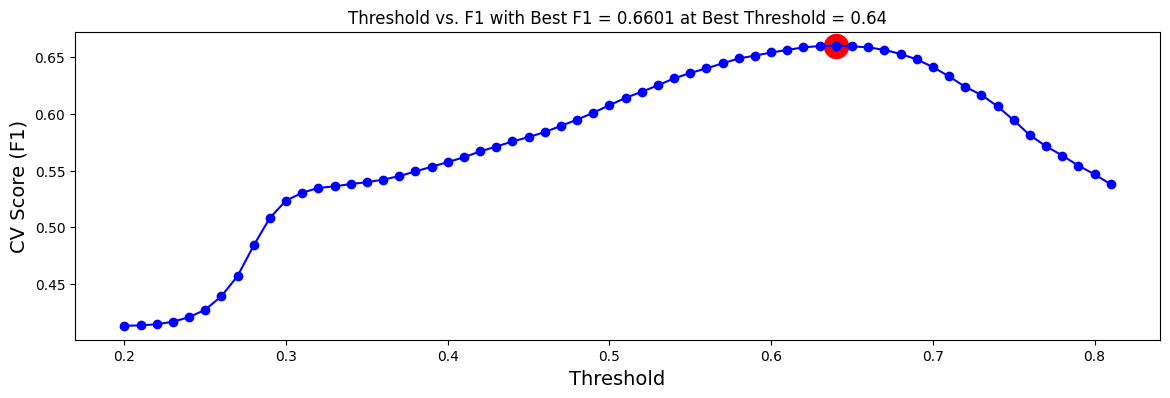

In [ ]:
best_f1, best_thres, (f1s, thresholds) = derive_cv_score(y_all, oof_pred, return_traces=True)
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(thresholds, f1s, "-o", color="blue")
ax.scatter([best_thres], [best_f1], color="red", s=300, alpha=1)
ax.set_title(f"Threshold vs. F1 with Best F1 = {best_f1:.4f} at Best Threshold = {best_thres:.3}")
ax.set_xlabel("Threshold", size=14)
ax.set_ylabel("CV Score (F1)", size=14)
plt.show()